In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline   # SMOTE para balanceamento
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

# Carregar os dados
candidatos_csv = pd.read_csv('app/db/candidatos_tecnologia.csv')
vagas_csv = pd.read_csv('app/db/vagas_tecnologia.csv')

# Funções de comparação de habilidades, experiência, salário e área de formação
def calcular_match_habilidades(habilidades_candidato, requisitos_vaga):
    if pd.isna(habilidades_candidato) or pd.isna(requisitos_vaga):
        return 0.0
    habi_candidato = [h.strip().lower() for h in str(habilidades_candidato).split(',')]
    reqs_vaga = [r.strip().lower() for r in str(requisitos_vaga).split(',')]
    matches = sum(1 for h in habi_candidato if any(h in r for r in reqs_vaga))
    return matches / len(reqs_vaga) if len(reqs_vaga) > 0 else 0.0

def verificar_match_experiencia(anos_experiencia, experiencia_min):
    if pd.isna(anos_experiencia) or pd.isna(experiencia_min):
        return 0
    return 1 if anos_experiencia >= experiencia_min else 0

def verificar_match_salario(pretensao, salario_min, salario_max):
    if pd.isna(pretensao) or pd.isna(salario_min) or pd.isna(salario_max):
        return 0.5
    if pretensao < salario_min:
        return 1.0
    elif pretensao > salario_max:
        return 0.0
    else:
        return 1 - ((pretensao - salario_min) / (salario_max - salario_min))

def verificar_match_area_formacao(formacao, area_vaga):
    if pd.isna(formacao) or pd.isna(area_vaga):
        return 0.5
    # Mapeamento simplificado de áreas de formação para áreas de vagas
    mapeamento = {
        "Ciência da Computação": ["Desenvolvimento Web", "Desenvolvimento Mobile", "Desenvolvimento Full-Stack", 
        "Ciência de Dados", "Machine Learning", "Inteligência Artificial"],
        "Engenharia de Software": ["Desenvolvimento Web", "Desenvolvimento Full-Stack", "Arquitetura de Software", 
        "DevOps", "QA e Testes"],
        "Sistemas de Informação": ["Desenvolvimento Web", "Business Intelligence", "Banco de Dados", 
        "Administração de Sistemas"],
        "Análise e Desenvolvimento de Sistemas": ["Desenvolvimento Web", "Desenvolvimento Mobile", 
                                                "Desenvolvimento Full-Stack"],
        "Engenharia da Computação": ["Desenvolvimento Embedded", "IoT", "Desenvolvimento Full-Stack", 
                                    "Machine Learning"],
        "Tecnologia em Redes": ["Administração de Redes", "Cloud Computing", "Segurança da Informação"],
        "Segurança da Informação": ["Segurança da Informação", "Administração de Redes"],
        "Tecnologia em Banco de Dados": ["Banco de Dados", "Engenharia de Dados", "Business Intelligence"],
        "Tecnologia em Desenvolvimento Web": ["Desenvolvimento Web", "UX/UI Design"],
        "Engenharia Elétrica": ["IoT", "Sistemas Embarcados"],
        "Matemática Computacional": ["Ciência de Dados", "Machine Learning", "Inteligência Artificial"]
    }
    formacao_lower = formacao.lower()
    area_vaga_lower = area_vaga.lower()
    for form, areas in mapeamento.items():
        if form.lower() in formacao_lower:
            for area in areas:
                if area.lower() in area_vaga_lower:
                    return 1.0
    return 0.3

# Gerar conjunto de dados simulado de candidatos e vagas
np.random.seed(42)
n_amostras = 5000
candidato_ids = np.random.choice(candidatos_csv['ID'].values, n_amostras)
vaga_ids = np.random.choice(vagas_csv['ID'].values, n_amostras)

aplicacoes = []

for i in range(n_amostras):
    candidato_id = candidato_ids[i]
    vaga_id = vaga_ids[i]
    candidato = candidatos_csv[candidatos_csv['ID'] == candidato_id].iloc[0]
    vaga = vagas_csv[vagas_csv['ID'] == vaga_id].iloc[0]
    
    match_habilidades = calcular_match_habilidades(candidato['Habilidades_Tecnicas'], vaga['Requisitos'])
    match_soft_skills = calcular_match_habilidades(candidato['Soft_Skills'], vaga['Requisitos'])
    match_experiencia = verificar_match_experiencia(candidato['Anos_Experiencia'], vaga['Experiencia_Min_Anos'])
    match_salario = verificar_match_salario(candidato['Pretensao_Salarial'], vaga['Salario_Min'], vaga['Salario_Max'])
    match_area = verificar_match_area_formacao(candidato['Formacao'], vaga['Area'])
    
    score_composto = (match_habilidades * 0.4 + 
                      match_soft_skills * 0.15 + 
                      match_experiencia * 0.2 + 
                      match_salario * 0.15 + 
                      match_area * 0.1)
    
    score_composto = score_composto * (0.85 + 0.3 * np.random.random())
    aderente = 1 if score_composto > 0.4 else 0
    
    aplicacao = {
        'CandidatoID': candidato_id,
        'VagaID': vaga_id,
        'Idade': candidato['Idade'],
        'Anos_Experiencia': candidato['Anos_Experiencia'],
        'Nivel_Formacao': candidato['Nivel_Formacao'],
        'Experiencia_Minima_Vaga': vaga['Experiencia_Min_Anos'],
        'Nivel_Vaga': vaga['Nivel'],
        'Match_Habilidades': match_habilidades,
        'Match_Soft_Skills': match_soft_skills,
        'Match_Experiencia': match_experiencia,
        'Match_Salario': match_salario,
        'Match_Area': match_area,
        'Score_Total': score_composto,
        'Aderente': aderente
    }
    aplicacoes.append(aplicacao)

aplicacoes_df = pd.DataFrame(aplicacoes)

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Prepara os dados para o modelo
X = aplicacoes_df.drop(['Aderente', 'CandidatoID', 'VagaID', 'Score_Total'], axis=1)
y = aplicacoes_df['Aderente']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns),
        ('num', StandardScaler(), X.select_dtypes(exclude=['object']).columns)
    ])

# Criando o modelo
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Aqui o SMOTE é aplicado separadamente
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Treinamento do modelo
model.fit(X_train, y_train)

# Predição e avaliação
y_pred = model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibir as métricas
print(f"Accuracy: {accuracy :.2f}")
print(f"Precision: {precision :.2f}")
print(f"Recall: {recall :.2f}")
print(f"F1 Score: {f1 :.2f}")

# Relatório detalhado
print(classification_report(y_test, y_pred))


Accuracy: 0.90
Precision: 0.77
Recall: 0.82
F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       759
           1       0.77      0.82      0.79       241

    accuracy                           0.90      1000
   macro avg       0.85      0.87      0.86      1000
weighted avg       0.90      0.90      0.90      1000



Distribuição das classes no y_test:
Aderente
0    759
1    241
Name: count, dtype: int64
Distribuição das classes no y_pred:
0    742
1    258
Name: count, dtype: int64


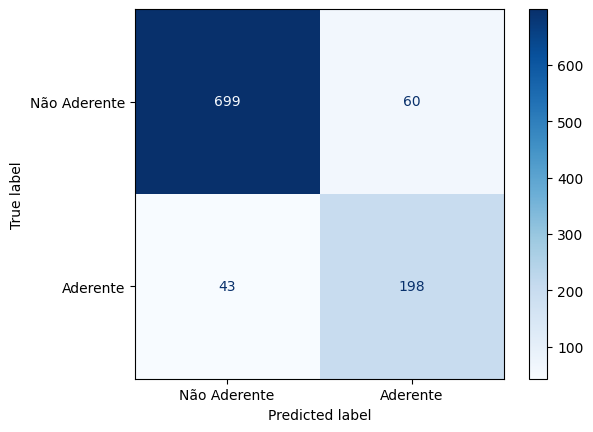

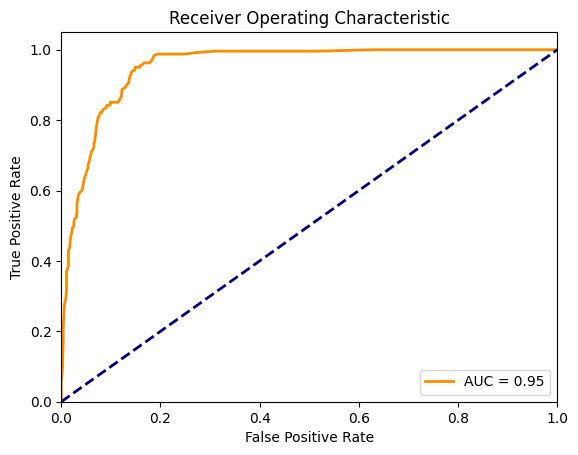

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Verifique a distribuição das classes
print("Distribuição das classes no y_test:")
print(y_test.value_counts())
print("Distribuição das classes no y_pred:")
print(pd.Series(y_pred).value_counts())

# Criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])  # Garantir que ambas as classes estão presentes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Aderente', 'Aderente'])

# Plotando a matriz de confusão
disp.plot(cmap=plt.cm.Blues)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


/tmp/ipykernel_10130/1964153340.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='Blues_d')


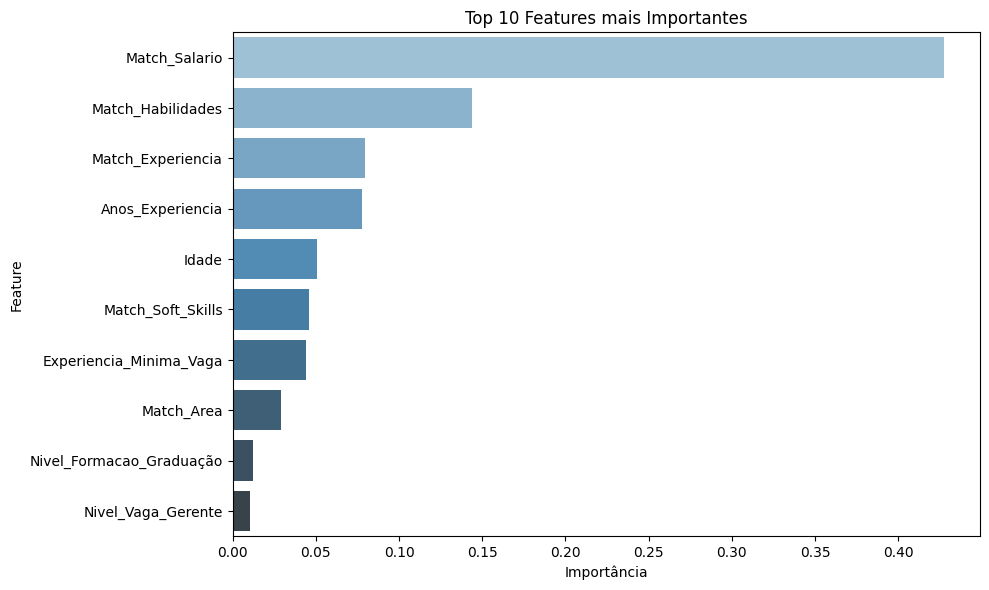


Modelo salvo como 'modelo_aderencia_candidatos.joblib'


In [9]:
# Importância das features
if hasattr(model[-1], 'feature_importances_'):
    ohe_features = []

    if hasattr(model[0], 'transformers_'):
        for name, _, column_names in model[0].transformers_:
            if name == 'cat':
                ohe = model[0].named_transformers_[name]
                for col_idx, col in enumerate(column_names):
                    categories = ohe.categories_[col_idx]
                    for cat in categories:
                        ohe_features.append(f"{col}_{cat}")
            else:
                ohe_features.extend(column_names)

    if not ohe_features:
        ohe_features = X.columns.tolist()

    feature_importances = model[-1].feature_importances_

    # Criar DataFrame com features e importâncias
    feat_df = pd.DataFrame({
        'Feature': [ohe_features[i] if i < len(ohe_features) else f"feature_{i}" for i in range(len(feature_importances))],
        'Importance': feature_importances
    })

    # Ordenar e selecionar o top 10
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

    # Plotar com Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='Blues_d')
    plt.title('Top 10 Features mais Importantes')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance_seaborn.png')
    plt.show()

    
# Salvar o modelo para uso posterior
joblib.dump(model, 'modelo_aderencia_candidatos.joblib')
print("\nModelo salvo como 'modelo_aderencia_candidatos.joblib'")

In [10]:
# Função procesasr varios modelos

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_feature_importances(model, model_name, X, save_dir="importancias"):
    os.makedirs(save_dir, exist_ok=True)

    # Coletar nomes das features após transformação
    ohe_features = []

    if hasattr(model[0], 'transformers_'):
        for name, _, column_names in model[0].transformers_:
            if name == 'cat':
                ohe = model[0].named_transformers_[name]
                for col_idx, col in enumerate(column_names):
                    categories = ohe.categories_[col_idx]
                    for cat in categories:
                        ohe_features.append(f"{col}_{cat}")
            else:
                ohe_features.extend(column_names)

    if not ohe_features:
        ohe_features = X.columns.tolist()

    # Checar se o modelo final tem feature_importances_
    if hasattr(model[-1], 'feature_importances_'):
        importances = model[-1].feature_importances_
        feat_df = pd.DataFrame({
            'Feature': [ohe_features[i] if i < len(ohe_features) else f"feature_{i}" for i in range(len(importances))],
            'Importance': importances
        }).sort_values(by="Importance", ascending=False)

        # Salvar CSV completo
        feat_df.to_csv(os.path.join(save_dir, f"{model_name}_importancias.csv"), index=False)

        # Plotar top 10
        top10 = feat_df.head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top10, palette='Blues_d')
        plt.title(f"Top 10 Features - {model_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{model_name}_top10.png"))
        plt.close()

        print(f"[✓] Importâncias do modelo '{model_name}' salvas com sucesso!")
    else:
        print(f"[x] Modelo '{model_name}' não possui 'feature_importances_'")



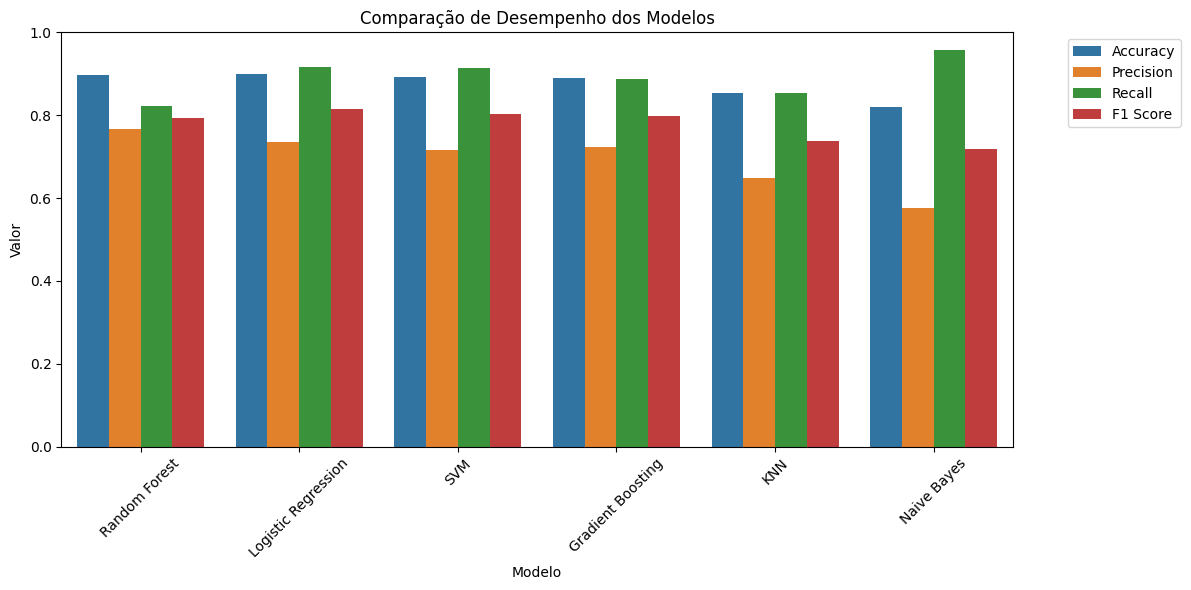

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    
}

resultados = []

for nome, clf in modelos.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', clf)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    resultados.append({
        'Modelo': nome,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

# DataFrame de resultados
resultados_df = pd.DataFrame(resultados)

# Gráfico com Seaborn
plt.figure(figsize=(12, 6))
resultados_df_melted = resultados_df.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')
sns.barplot(data=resultados_df_melted, x='Modelo', y='Valor', hue='Métrica')
plt.title('Comparação de Desempenho dos Modelos')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
